# Apprendimento supervisionato - summary

## In questa sezione viene applicato l'apprendimento supervisionato sul riassunto della recensione, cioè sulla colonna summary

### Import delle librerie e moduli necessari

In [1]:
# librerie generali
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# librerie per la rappresentazione del dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# libreria per suddividere il dataset in train e test set
from sklearn.model_selection import train_test_split

# libreria utilizzata per l'ottimizzazione dei parametri
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# librerie utilizzate per le misure
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

# libreria utilizzata per la cross validation
from sklearn.model_selection import cross_val_score

# libreria per il Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# libreria utilizzata per il Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# libreria utilizzata per il KNN
from sklearn.neighbors import KNeighborsClassifier

# libreria utilizzata per la rete neurale
from sklearn.neural_network import MLPClassifier

# libreria utilizzata per il support vector machine
from sklearn.svm import SVC

# libreria utilizzata per l'ensamble learning
from sklearn.ensemble import StackingClassifier

# seed utilizzato per la generazione del train e test set
random_seed = 3

# 1. Creazione dataset con rappresentazione tf-idf

In [2]:
clean_dataset = pd.read_csv("../datasets/clean_dataset.csv", index_col=0)
clean_dataset.head()

,rating,reviewText,summary,sentiment,numberPositiveReview,numberNegativeReview,numberPositiveSummary,numberNegativeSummary
0,3,jace rankin may short nothing mess man haul sa...,entertaining average,0,0.06,0.11,0.50,0.00
1,5,great short read want put read one sit sex sce...,terrific menage scene,1,0.19,0.03,0.33,0.00
2,3,ill start say first four book expect 34conclud...,snapdragon alley,0,0.05,0.02,0.00,0.00
3,3,aggie angela lansbury carry pocketbook instead...,light murder cozy,0,0.10,0.13,0.33,0.33
4,4,expect type book library please find price right,book,1,0.12,0.00,0.00,0.00


In [3]:
def createDataframeWithTfIdf(dataframe):
    summary = dataframe['summary'].to_numpy()
    vectorizer = TfidfVectorizer(sublinear_tf=True)
    tfidf_vector = vectorizer.fit_transform(summary)
    tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=summary, columns=vectorizer.get_feature_names())
    
    tfidf_df['numberPositiveSummary'] = dataframe['numberPositiveSummary'].to_numpy()
    tfidf_df['numberNegativeSummary'] = dataframe['numberNegativeSummary'].to_numpy()
    tfidf_df.reset_index(drop=True, inplace=True)
    sentiment = dataframe['sentiment']
    return tfidf_df, sentiment

In [4]:
dataset, labels = createDataframeWithTfIdf(clean_dataset)

In [5]:
print(dataset.shape)

(11891, 5121)


# 2. Definizione della funzione K-fold cross validation

## Questa funzione viene utilizzata per effettuare la K-fold cross validation sui varia classificatori. La cross validation viene effettuata per valori di k in [10, 15]

In [6]:
def kCrossValidation(model, dataset, labels):
    k = []
    acc = []
    dev = []

    #nota, non viene effettuato lo shuffle dei fold, quindi sono sempre gli stessi, sono già istanziati
    for i in range(10, 16):
        scores = cross_val_score(model, dataset, labels, cv=i)
        print("K cross validation, k= ", i)
        k.append(i)
        print("Average scores: ", scores.mean())
        acc.append(scores.mean())
        print("Standard Deviation of scores: ", scores.std())
        dev.append(scores.std())
        print("\n\n")

In [7]:
def kCrossValidationReduced(model, dataset, labels):
    k = []
    acc = []
    dev = []

    folds = [5, 10]
    #nota, non viene effettuato lo shuffle dei fold, quindi sono sempre gli stessi, sono già istanziati
    for i in folds:
        print("Calculating with " + str(i) + " folds...")
        scores = cross_val_score(model, dataset, labels, cv=i)
        print("K cross validation, k= ", i)
        k.append(i)
        print("Average scores: ", scores.mean())
        acc.append(scores.mean())
        print("Standard Deviation of scores: ", scores.std())
        dev.append(scores.std())
        print("\n\n")

## 2.1 Definizione funzione per la visualizzazione dei grafici

In [8]:
def report_scores(Y_test, y_predicted):
    #print("Accuracy score: ", accuracy_score(Y_test, y_predicted))
    print(classification_report(Y_test, y_predicted, target_names=["Negativo", "Positivo"]))
    
    cf_matrix = confusion_matrix(Y_test, y_predicted)

    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Negativo','Positivo'])
    ax.yaxis.set_ticklabels(['Negativo','Positivo'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# 3. Random Forest

## 3.1 Random Forest: Feature Selection

### Prima di applicare il random forest per la classificazione, viene effettuata la feature selection per estrarre le feature più importanti, avendo il dataset nella rappresentazione tf-idf

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    
rf = RandomForestClassifier(criterion = 'entropy', random_state=random_seed)
rf.fit(X_train, Y_train)
y_pred=rf.predict(X_test)

# feature selection
sel = SelectFromModel(rf, prefit=True)
selected_feat = dataset.columns[(sel.get_support())]
print("Numero feature selezionate: " + str(len(selected_feat)))

featureSelection_df = dataset.loc[:, sel.get_support()]
print(featureSelection_df.shape)

Numero feature selezionate: 959
(11891, 959)


In [10]:
featureSelection_df.to_csv("../datasets/featureSelectionSummary_df.csv")

## 3.2 Random Forest: Parameter Tuning

### Dopo aver effettuato la feature selection, viene attuato il paramater tuning sulle feature più importanti tramite una ricerca esaustiva dello spazio di ricerca

### Parametri su cui viene effettuata la ricerca

In [10]:
n_estimators_list = [40,60,80,100]
criterion_list = ['entropy']
max_depth_list = [35,55]
max_depth_list.append(None)
min_samples_split_list = [15, 30]
min_samples_leaf_list = [5, 15, 30]
max_features_list = ['log2']

In [11]:
params_grid = {
    'n_estimators': n_estimators_list,
    'criterion': criterion_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


def my_acc_score(model, truncated_df, labels):
    return metrics.accuracy_score(labels, model.predict(truncated_df))

### Salvataggio train-test-split

In [13]:
X_train.to_csv("../resources/X_train_Summary.csv", index = False)
Y_train.to_csv("../resources/Y_train_Summary.csv", index = False)
X_test.to_csv("../resources/X_test_Summary.csv", index = False)
Y_test.to_csv("../resources/Y_test_Summary.csv", index = False)

### Ricerca dei parametri migliori

In [15]:
cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_seed)

In [15]:
rf_searchParameter = GridSearchCV(estimator=RandomForestClassifier(random_state=random_seed),
                            param_grid=params_grid,
                            cv=cross_validation,
                            return_train_score=True,
                            verbose=2,
                            scoring = my_acc_score
                            )

rf_searchParameter.fit(X_train, Y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=40; total time=   0.2s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n_estimators=60; total time=   0.3s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=5, min_samples_split=15, n

[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.1s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.1s
[CV] END criterion=entropy, max_depth=35, max_features=log2, min_samples_leaf=30, min_samples_split=30, n_estimators=60; total time=   0.1s
[CV] END criterion=

[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.1s
[CV] END criterion=entropy, max_depth=55, max_features=log2, min_samples_leaf=30, min_samples_split=15, n_estimators=60; total time=   0.1s
[CV] END criterion

[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.1s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=15, n_estimators=100; total time=   0.2s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=40; total time=   0.0s
[CV] END criterion=entropy, max_depth=None, max_features=log2, min_samples_leaf=15, min_samples_split=30, n_estimators=60; total time=   0.1s
[CV

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
             estimator=RandomForestClassifier(random_state=3),
             param_grid={'criterion': ['entropy'], 'max_depth': [35, 55, None],
                         'max_features': ['log2'],
                         'min_samples_leaf': [5, 15, 30],
                         'min_samples_split': [15, 30],
                         'n_estimators': [40, 60, 80, 100]},
             return_train_score=True,
             scoring=<function my_acc_score at 0x000001D96E651F70>, verbose=2)

### Parametri migliori trovati

In [16]:
best_param = rf_searchParameter.best_params_
print("Parametri migliori trovati:\n")
for pair in best_param.items():
    print(pair)

Parametri migliori trovati:

('criterion', 'entropy')
('max_depth', 55)
('max_features', 'log2')
('min_samples_leaf', 5)
('min_samples_split', 15)
('n_estimators', 80)


"\n('criterion', 'entropy')\n('max_depth', 35)\n('max_features', 'log2')\n('min_samples_leaf', 5)\n('min_samples_split', 15)\n('n_estimators', 80)\n"

In [17]:
df_cv_results = pd.DataFrame(rf_searchParameter.cv_results_)
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                           'param_n_estimators', 'param_min_samples_split','param_min_samples_leaf',
                           'param_max_features', 'param_max_depth','param_criterion']]
df_cv_results.sort_values('rank_test_score', inplace=True)
df_cv_results[:10]

,rank_test_score,mean_test_score,mean_train_score,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion
26,1,0.703849,0.726083,80,15,5,log2,55,entropy
30,2,0.703744,0.725504,80,30,5,log2,55,entropy
54,3,0.703534,0.725242,80,30,5,log2,None,entropy
50,4,0.703113,0.725557,80,15,5,log2,None,entropy
2,5,0.702587,0.725978,80,15,5,log2,35,entropy
6,6,0.702377,0.725400,80,30,5,log2,35,entropy
27,7,0.702061,0.724033,100,15,5,log2,55,entropy
51,8,0.701956,0.723350,100,15,5,log2,None,entropy
31,9,0.701851,0.723455,100,30,5,log2,55,entropy
49,10,0.701641,0.722666,60,15,5,log2,None,entropy


## 3.3 Random Forest: Classificazione

### Prendo i parametri migliori trovati per effettuare la classificazione

In [18]:
n_estimators_found = best_param.get('n_estimators')
max_depth_found = best_param.get('max_depth')
max_features_found = best_param.get('max_features')
min_samples_leaf_found = best_param.get('min_samples_leaf')
min_samples_split_found = best_param.get('min_samples_split')
criterion_found = best_param.get('criterion')

### Task di classificazione

In [19]:
rf = RandomForestClassifier(n_estimators = n_estimators_found, 
                            criterion = criterion_found,
                            class_weight= 'balanced',
                            max_depth= max_depth_found,
                            max_features= max_features_found,
                            min_samples_leaf= min_samples_leaf_found,
                            min_samples_split= min_samples_split_found,
                            random_state = random_seed
                           )
rf.fit(X_train, Y_train)

train_prediction = rf.predict(X_train)
test_prediction = rf.predict(X_test)

Accuracy train score:  0.7252943650126157
Accuracy test score:  0.689365279529214
              precision    recall  f1-score   support

    Negativo       0.67      0.73      0.70      1172
    Positivo       0.71      0.65      0.68      1207

    accuracy                           0.69      2379
   macro avg       0.69      0.69      0.69      2379
weighted avg       0.69      0.69      0.69      2379



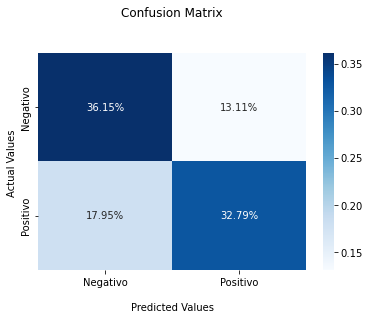

In [20]:
accuracy_train_rf = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_rf = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_rf)
print("Accuracy test score: ", accuracy_test_rf)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [21]:
kCrossValidation(rf, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.7069210055763264
Standard Deviation of scores:  0.009433299458828374



K cross validation, k=  11
Average scores:  0.7082667563703641
Standard Deviation of scores:  0.012746763533825778



K cross validation, k=  12
Average scores:  0.704482004709048
Standard Deviation of scores:  0.012060705029884145



K cross validation, k=  13
Average scores:  0.7076779589460295
Standard Deviation of scores:  0.014423412986374206



K cross validation, k=  14
Average scores:  0.7080141738674267
Standard Deviation of scores:  0.017108031725980015



K cross validation, k=  15
Average scores:  0.7081827098220541
Standard Deviation of scores:  0.01544624590792239





# 4. Multinomial Naive Bayes

## Task di classificazione

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)
nb = MultinomialNB()
nb.fit(X_train, Y_train)

train_prediction = nb.predict(X_train)
test_prediction = nb.predict(X_test)

Accuracy train score:  0.7666105971404542
Accuracy test score:  0.7200504413619168
              precision    recall  f1-score   support

    Negativo       0.75      0.64      0.69      1172
    Positivo       0.70      0.79      0.74      1207

    accuracy                           0.72      2379
   macro avg       0.72      0.72      0.72      2379
weighted avg       0.72      0.72      0.72      2379



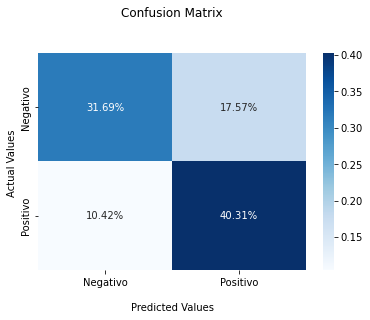

In [23]:
accuracy_train_nb = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nb = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_nb)
print("Accuracy test score: ", accuracy_test_nb)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [24]:
kCrossValidation(nb, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.727777597161657
Standard Deviation of scores:  0.011131665635515984



K cross validation, k=  11
Average scores:  0.7276091161382557
Standard Deviation of scores:  0.01472926193519901



K cross validation, k=  12
Average scores:  0.7290374311565028
Standard Deviation of scores:  0.009581709593974063



K cross validation, k=  13
Average scores:  0.7285343215572436
Standard Deviation of scores:  0.01289683269086323



K cross validation, k=  14
Average scores:  0.7276938761370272
Standard Deviation of scores:  0.016852203167390428



K cross validation, k=  15
Average scores:  0.7290376442015786
Standard Deviation of scores:  0.014501753386765282





# 5. KNN

## 5.1 Trovare il k migliore

### Prima di effettuare la classifcazione con il KNN, si cerca il valore k migliore che identifica il numero di neighbors su cui basarsi per la classficazione

### La ricerca di k viene effettuata per i seguenti valori: [9,11,13,15,17,19,97]

### Funzione che ricerca il k migliore

In [25]:
def findBestK(dataset, labels):
    X_train, X_test, Y_train, Y_test = train_test_split(dataset, labels, test_size=0.2, random_state=random_seed)
    error = []
    
    acc_train = []
    acc_test = []
    max_acc_test = 0
    max_acc_train = 0
    best_k = 0
    
    root = int(math.sqrt(X_train.shape[0]))
    k = [9,11,13,15,17,19]
    k.append(root)
    
    for i in k:
        print(str(i) + " Neighbors")
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        
        error.append(np.mean(pred_i != Y_test))
        
        print("train: ", knn.score(X_train, Y_train))
        print("test: ", knn.score(X_test, Y_test))
        acc_train.append(knn.score(X_train, Y_train))
        acc_test.append(knn.score(X_test, Y_test))
        print()
        if knn.score(X_train, Y_train) >= max_acc_train and knn.score(X_test, Y_test) >= max_acc_test:
            best_k = i
            max_acc_test = knn.score(X_test, Y_test)
            max_acc_train = knn.score(X_train, Y_train)
        
    print("\nErrori per i vari k:\n")
    print(error)
    
    x=[9,11,13,15,17,19,97]
    values = range(len(x))

    plt.figure(figsize=(12, 6))
    plt.xticks(values,x)
    plt.plot(values, error, color='red', linestyle='dashed', marker='o',
             markerfacecolor='blue', markersize=10)
    plt.title('Error Rate K Value')
    plt.xlabel('K Value')
    plt.ylabel('Mean Error')

    return best_k

## 5.2 KNN: Classificazione

### Task di classificazione

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)


9 Neighbors
train:  0.7707106812447435
test:  0.7095418242959226

11 Neighbors
train:  0.759251471825063
test:  0.717948717948718

13 Neighbors
train:  0.7529436501261564
test:  0.7040773434216057

15 Neighbors
train:  0.7449537426408747
test:  0.7015552753257671

17 Neighbors
train:  0.7389613120269134
test:  0.7032366540563262

19 Neighbors
train:  0.7280277544154752
test:  0.6969314838167298

97 Neighbors
train:  0.6624264087468461
test:  0.6561580496006726


Errori per i vari k:

[0.29045817570407734, 0.28205128205128205, 0.2959226565783943, 0.2984447246742329, 0.2967633459436738, 0.3030685161832703, 0.34384195039932747]


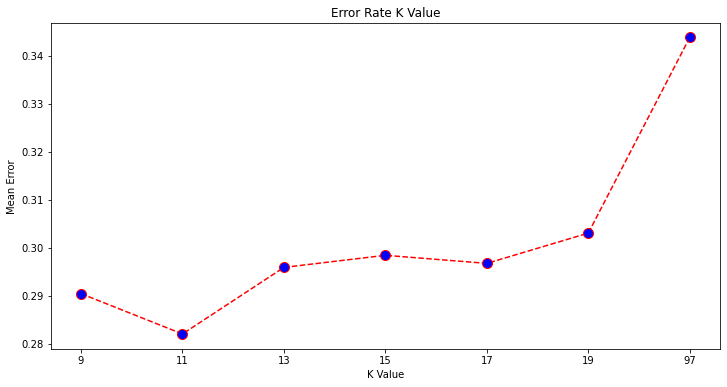

In [27]:
k = findBestK(featureSelection_df, labels)
knc = KNeighborsClassifier(n_neighbors=k, weights="distance")
knc.fit(X_train, Y_train)


train_prediction = knc.predict(X_train)
test_prediction = knc.predict(X_test)


Accuracy train score:  0.9362910008410429
Accuracy test score:  0.7246742328709542
              precision    recall  f1-score   support

    Negativo       0.70      0.76      0.73      1172
    Positivo       0.75      0.69      0.72      1207

    accuracy                           0.72      2379
   macro avg       0.73      0.73      0.72      2379
weighted avg       0.73      0.72      0.72      2379



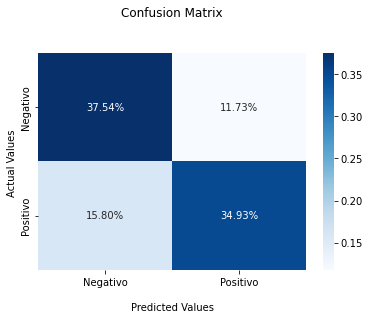

In [28]:
accuracy_train_knn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_knn = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_knn)
print("Accuracy test score: ", accuracy_test_knn)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [29]:
kCrossValidation(knc, featureSelection_df, labels)

K cross validation, k=  10
Average scores:  0.7316445568976119
Standard Deviation of scores:  0.009842851469782005



K cross validation, k=  11
Average scores:  0.7322344630392734
Standard Deviation of scores:  0.014452003256739647



K cross validation, k=  12
Average scores:  0.7329065121446554
Standard Deviation of scores:  0.015565535059378069



K cross validation, k=  13
Average scores:  0.7320671484534167
Standard Deviation of scores:  0.012144465655167296



K cross validation, k=  14
Average scores:  0.7367774247508191
Standard Deviation of scores:  0.016146693342042814



K cross validation, k=  15
Average scores:  0.7343369593369593
Standard Deviation of scores:  0.017037443828730695





# 6. Artificial Neural Network

## 6.1 Ottimizzazione dei parametri della rete neurale

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

In [12]:
mlp = MLPClassifier(max_iter=200, random_state = random_seed)

### Paramatri su cui viene effettuata la ricerca

In [13]:
parameter_space = {
    'hidden_layer_sizes': [(200,150,100)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.005, 0.0001],
    'learning_rate': ['constant'],
    }

### Ricerca dei parametri

In [16]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=cross_validation)
clf.fit(X_train, Y_train)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=3, shuffle=True),
             estimator=MLPClassifier(random_state=3), n_jobs=-1,
             param_grid={'activation': ['relu', 'logistic'],
                         'alpha': [0.005, 0.0001],
                         'hidden_layer_sizes': [(200, 150, 100)],
                         'learning_rate': ['constant'],
                         'solver': ['adam', 'sgd']})

### Parametri migliori trovati

In [17]:
print('Parametri migliori:\n', clf.best_params_)

Parametri migliori:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}


"\n'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'\n"

In [18]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.746 (+/-0.013) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.735 (+/-0.011) for {'activation': 'relu', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.749 (+/-0.014) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.735 (+/-0.011) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.744 (+/-0.013) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'adam'}
0.502 (+/-0.000) for {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (200, 150, 100), 'learning_rate': 'constant', 'solver': 'sgd'}
0.743 (+/-0.021) for {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (200, 150, 100), 'learning_rat

## 6.2 Artificial Neural Network: Classificazione

### Prendo i parametri migliori trovati

In [19]:
best_params = clf.best_params_ 

hidden_layer_sizes_found = best_params.get('hidden_layer_sizes')
activation_found = best_params.get('activation')
solver_found = best_params.get('solver')
alpha_found = best_params.get('alpha')
learning_rate_found = best_params.get('learning_rate')

### Task di classificazione

In [20]:
mlp = MLPClassifier(max_iter=200, 
                    random_state = random_seed,
                    hidden_layer_sizes = hidden_layer_sizes_found,
                    activation = activation_found,
                    solver = solver_found,
                    alpha = alpha_found,
                    learning_rate = learning_rate_found
                   )

mlp.fit(X_train, Y_train)

train_prediction = mlp.predict(X_train)
test_prediction = mlp.predict(X_test)

Accuracy train score:  0.932296047098402
Accuracy test score:  0.735603194619588
              precision    recall  f1-score   support

    Negativo       0.71      0.78      0.74      1172
    Positivo       0.76      0.70      0.73      1207

    accuracy                           0.74      2379
   macro avg       0.74      0.74      0.74      2379
weighted avg       0.74      0.74      0.74      2379



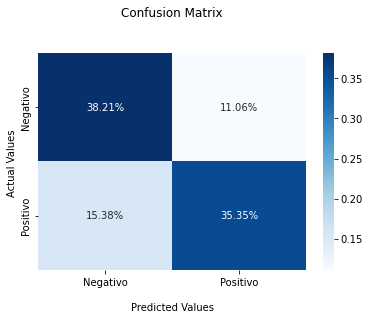

In [21]:
accuracy_train_nn = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_nn = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_nn)
print("Accuracy test score: ", accuracy_test_nn)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [22]:
kCrossValidationReduced(mlp, featureSelection_df, labels)

Calculating with 5 folds...
K cross validation, k=  5
Average scores:  0.7537621202624167
Standard Deviation of scores:  0.0098679644034411



Calculating with 10 folds...
K cross validation, k=  10
Average scores:  0.755445576043706
Standard Deviation of scores:  0.016176849437104245





# 7. Support Vector Machine

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(featureSelection_df, labels, test_size=0.2, random_state=random_seed)

## Valori su cui ho ottimizzato il classificatore SVC

In [25]:
# valori su cui ho ottimizzato il classificatore SVC

# kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
# C_values = [0.5,1,10,100]
# gamma_values = ['scale', 1, 0.1, 0.01, 0.001, 0.0001]

# parametri migliori
kernel_found = 'linear'
C_found = 0.5
gamma_found = 0.0001

### Task di classificazione

In [26]:
svm = SVC(random_state=random_seed, kernel = kernel_found, C = C_found, gamma = gamma_found)
svm.fit(X_train, Y_train)

train_prediction = svm.predict(X_train)
test_prediction = svm.predict(X_test)

Accuracy train score:  0.7987804878048781
Accuracy test score:  0.73224043715847
              precision    recall  f1-score   support

    Negativo       0.72      0.75      0.73      1172
    Positivo       0.75      0.71      0.73      1207

    accuracy                           0.73      2379
   macro avg       0.73      0.73      0.73      2379
weighted avg       0.73      0.73      0.73      2379



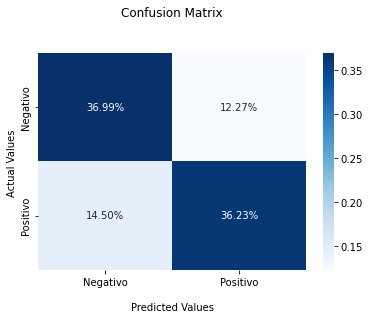

In [27]:
accuracy_train_svm = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_svm = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_svm)
print("Accuracy test score: ", accuracy_test_svm)

report_scores(Y_test, test_prediction)

## K-fold Cross Validation

In [28]:
kCrossValidationReduced(svm, featureSelection_df, labels)

Calculating with 5 folds...
K cross validation, k=  5
Average scores:  0.7489692363549716
Standard Deviation of scores:  0.0055593595701547115



Calculating with 10 folds...
K cross validation, k=  10
Average scores:  0.7491389558346467
Standard Deviation of scores:  0.012027142749467094





# 8. Confronto modelli

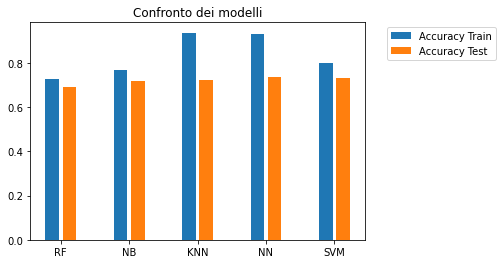

In [43]:
x_train = [1,5,9,13,17]
x_test = [2,6,10,14,18]

accuracy_train = [accuracy_train_rf, accuracy_train_nb, accuracy_train_knn, accuracy_train_nn, accuracy_train_svm]
accuracy_test = [accuracy_test_rf, accuracy_test_nb, accuracy_test_knn, accuracy_test_nn, accuracy_test_svm]

x_labels = [1.5,5.5,9.5,13.5,17.5]
name_labels = ["RF", "NB", "KNN", "NN", "SVM"]
plt.bar(x_train, accuracy_train, label='Accuracy Train')
plt.bar(x_test, accuracy_test, label='Accuracy Test')
plt.title("Confronto dei modelli")
plt.xticks(x_labels, name_labels)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 9. Ensamble learning

## In questa sezione vengono combinati i migliori classificatori ottenuti con l'ensamble learning

In [44]:
estimators = [['knn', knc], ['rf', rf], ['nb', nb], ['svm', svm]]

cross_validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

clf = StackingClassifier(
    estimators=estimators, n_jobs = -1, cv = cross_validation)

clf.fit(X_train, Y_train)

train_prediction = clf.predict(X_train)
test_prediction = clf.predict(X_test)

Accuracy train score:  0.8973927670311186
Accuracy test score:  0.7473728457335015
              precision    recall  f1-score   support

    Negativo       0.74      0.75      0.75      1172
    Positivo       0.75      0.74      0.75      1207

    accuracy                           0.75      2379
   macro avg       0.75      0.75      0.75      2379
weighted avg       0.75      0.75      0.75      2379



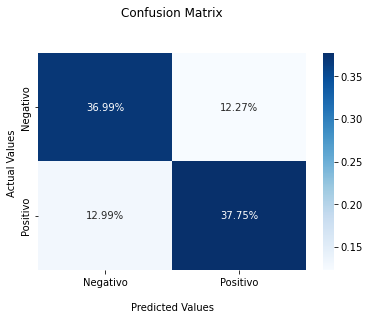

In [45]:
accuracy_train_clf = metrics.accuracy_score(Y_train, train_prediction)
accuracy_test_clf = metrics.accuracy_score(Y_test, test_prediction)

print("Accuracy train score: ", accuracy_train_clf)
print("Accuracy test score: ", accuracy_test_clf)

report_scores(Y_test, test_prediction)